In [2]:
import os
import glob
import numpy as np 
import xarray as xr
import pandas as pd
import datetime
from datetime import date, timedelta
import dask
# import re
import scipy.stats as stats
import scipy.signal as signal
# from skimage.measure import find_contours
# from statsmodels.tsa.stattools import acf, pacf
import isla_interp_utils as isla_interp


# Plotting utils 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker
import cartopy
import cartopy.crs as ccrs
# import seaborn as sns


In [3]:
import dask
dask.config.set({'logging.distributed': 'error'})

from dask_jobqueue import PBSCluster

# For Casper
cluster = PBSCluster(
    queue="casper",
    walltime="03:00:00",
    account="P93300041",
    memory="8GB",
    resource_spec="select=1:ncpus=1:mem=8GB",
    cores=1,
    processes=1,
)

from dask.distributed import Client

# Connect client to the remote dask workers
client = Client(cluster)
client

cluster.scale(28)
client.wait_for_workers(28)
# cluster.scale(8)
# client.wait_for_workers(8)


In [4]:
client

<Client: 'tcp://128.117.208.173:33181' processes=27 threads=27, memory=201.15 GiB>

## Read in data

In [5]:
%%time 
# Obs: 
# obs_ds = xr.open_zarr("/glade/derecho/scratch/mdfowler/ENSOmetrics_Obs.zarr",consolidated=True)
obs_ds = xr.open_dataset('/glade/derecho/scratch/mdfowler/ENSOmetrics_Obs.nc')

# CESM: 
# cesm1_ds = xr.open_zarr("/glade/derecho/scratch/mdfowler/ENSOmetrics_CESM1.zarr",consolidated=True)
# cesm2_ds = xr.open_zarr("/glade/derecho/scratch/mdfowler/ENSOmetrics_CESM2.zarr",consolidated=True)
# dev_ds   = xr.open_zarr("/glade/derecho/scratch/mdfowler/ENSOmetrics_CESM3dev.zarr",consolidated=True)

cesm1_ds = xr.open_dataset("/glade/derecho/scratch/mdfowler/ENSOmetrics_CESM1.nc")
cesm2_ds = xr.open_dataset("/glade/derecho/scratch/mdfowler/ENSOmetrics_CESM2.nc")
dev_ds   = xr.open_dataset("/glade/derecho/scratch/mdfowler/ENSOmetrics_CESM3dev.nc")



CPU times: user 576 ms, sys: 142 ms, total: 718 ms
Wall time: 1.31 s


In [5]:
dev_ds.startYear.values

array([   6.,    6.,    6.,    6.,    6.,    6.,    6.,    6.,    6.,
          6.,    6.,    6.,    6.,    6.,    6.,    6.,    6.,    6.,
          6.,  106.,    6.,    6.,    6.,    6.,    6.,   65., 1940.,
          6.,   50.,    6.,    6.,    6.,    6.,    6.])

## Get W500 info? 

In [6]:
def preprocess_h0(DS):
    climoVar_list = ['TS','PRECT','TAUX']

    dsSel = DS.sel(lat=slice(-10,10))

    if "OMEGA500" not in dsSel:
        omega500 = isla_interp.interp_hybrid_to_pressure(
              dsSel.OMEGA, dsSel.PS, dsSel.hyam, dsSel.hybm, p0=1e5, new_levels = np.array([50000.]), method='log', 
              lev_dim='lev', extrapolate=False, variable='other',
              t_bot = dsSel.T.isel(lev=dsSel.lev.size-1), phi_sfc = phis)
    else: 
        omega500 = dsSel.OMEGA500
    
    
    dsSel = dsSel[climoVar_list]
    dsSel['OMEGA500'] = omega500
    
    
    return dsSel
    

In [7]:
def getWesternPoint(DS, contourLev):
    corrs_sel = DS.sel(lon=slice(120,240), lat=slice(-10,10))
    c2 = plt.contour(corrs_sel.lon.values,corrs_sel.lat.values ,  corrs_sel, [contourLev], transform=ccrs.PlateCarree())
    
    # Add contour marker
    maybeLon = []
    maybeLat = []
    lenSeg = 0
    for iSegs in range(len(c2.allsegs[0])): 
        dat0 = c2.allsegs[0][iSegs]
        western_most_lon = np.nanmin(dat0[:,0])
        iMatchLat = np.where(dat0[:,0]==western_most_lon)[0]
        maybeLon = np.append(maybeLon, western_most_lon)
        maybeLat = np.append(maybeLat, dat0[int(iMatchLat[0]),1])
        if len(dat0)>lenSeg:
            lenSeg= len(dat0)
            iselSeg = iSegs
    
    # axs.plot(maybeLon[iselSeg], maybeLat[iselSeg], 'o', color='limegreen', markersize=5, transform=ccrs.PlateCarree() )
    
    return maybeLon[iselSeg],maybeLat[iselSeg]

In [8]:
dataDir = '/glade/derecho/scratch/hannay/archive/'
altDir  = '/glade/derecho/scratch/gmarques/archive/'
archDir = '/glade/campaign/cesm/development/cross-wg/cesm3_development/'

caseNames = [
             'b.e23_alpha16b.BLT1850.ne30_t232.054',
             'b.e23_alpha16g.BLT1850.ne30_t232.064',
             'b.e23_alpha16g.BLT1850.ne30_t232.075',
             'b.e23_alpha16g.BLT1850.ne30_t232.076',
             'b.e23_alpha16g.BLT1850.ne30_t232.078',
             'b.e23_alpha16g.BLT1850.ne30_t232.082b',
             'b.e23_alpha16g.BLT1850.ne30_t232.084b', 
             # 'b.e23_alpha17f.BLT1850.ne30_t232.091',  # Doesn't have lat, just ncol
             # 'b.e23_alpha17f.BLT1850.ne30_t232.092',  # Doesn't have lat, just ncol 
             'b.e30_beta02.BLT1850.ne30_t232.104',
             'b.e30_alpha03d.BLT1850.ne30_t232_wgx3.112',
             # 'b.e30_beta04.BLT1850.ne30_t232_wgx3.116', # Lost to scratch 
             # 'b.e30_beta04.BLT1850.ne30_t232_wgx3.118', # Lost to scratch
             'b.e30_beta04.BLT1850.ne30_t232_wgx3.121', 
             'b.e30_beta04.BLTHIST.ne30_t232_wgx3.121', 
             'b.e30_beta04.BLTHIST.ne30_t232_wgx3.121', 
             'b.e30_beta04.BLT1850.ne30_t232_wgx3.121_1pctco2',
             'b.e30_beta04.BLT1850.ne30_t232_wgx3.121_4xco2',
             'b.e30_beta05.BLT1850.ne30_t232_wgx3.125',
             'b.e30_beta05.BLT1850.ne30_t232_wgx3.126',
             'b.e30_beta05.BLT1850.ne30_t232_wgx3.127',
             'b.e30_beta05.BLT1850.ne30_t232_wgx3.129',
             # 'b.e30_alpha06b.B1850C_LTso.ne30_t232_wgx3.132',
            ]

shortNames = [
              '054',
              '064',
              '075',
              '076',
              '078',
              '082b',
              '084b',
              # '091',
              # '092',
              '104',
              '112',
              # '116',
              # '118',
              '121', 
              '121_hist',
              '121_hist_1979+',
              '121_1pctco2',
              '121_4xco2',
              '125',
              '126',
              '127',
              '129',
              # '132',
             ]

for iCase in range(len(caseNames)):
    if ((shortNames[iCase]=='112') | (shortNames[iCase]=='127') | (shortNames[iCase]=='129')):
        listFiles = np.sort(glob.glob(altDir+caseNames[iCase]+'/atm/hist/'+'*.h0a.*.nc'))
    elif ((shortNames[iCase]=='104') | (shortNames[iCase]=='092') | (shortNames[iCase]=='091') | 
          (shortNames[iCase]=='121') | (shortNames[iCase]=='121_hist') | (shortNames[iCase]=='121_hist_1979+') | 
          (shortNames[iCase]=='121_1pctco2') | (shortNames[iCase]=='121_4xco2') ):
        listFiles = np.sort(glob.glob(archDir+caseNames[iCase]+'/atm/hist/'+'*.h0a.*.nc'))
    elif ((shortNames[iCase]=='054') | (shortNames[iCase]=='064') |  (shortNames[iCase]=='075') | 
          (shortNames[iCase]=='076') | (shortNames[iCase]=='078') | (shortNames[iCase]=='082b') | 
          (shortNames[iCase]=='084b')):
        listFiles = np.sort(glob.glob(archDir+caseNames[iCase]+'/atm/hist/'+'*.h0.*.nc'))
    else:
        listFiles = np.sort(glob.glob(dataDir+caseNames[iCase]+'/atm/hist/'+'*.h0a.*.nc'))


    # Read in files, but ignore first year
    camDS = xr.open_mfdataset(listFiles[12::], preprocess=preprocess_h0, concat_dim='time', combine='nested', 
                                 decode_times=True, data_vars='minimal', parallel=True)

    # Limit time to match what's used in the ENSO analysis? 
    if shortNames[iCase]=='121_hist_1979+':
        iTimes = np.where( camDS['time.year']>=1979 )[0]
        camDS  = camDS.isel(time=np.arange(iTimes[0], iTimes[-1]) )
    else:
        iCaseMatch = np.where(dev_ds.case.values==shortNames[iCase])[0][0]
        iTimes = np.where( (camDS['time.year']>=dev_ds.startYear[iCaseMatch]) & 
                           (camDS['time.year']<=dev_ds.endYear[iCaseMatch]) )[0]
        camDS  = camDS.isel(time=np.arange(iTimes[0], iTimes[-1]+1)) 
        

    # Add case name and concat
    caseDS   = camDS.squeeze().assign_coords({"case":  shortNames[iCase]})
    print('Start year: ', caseDS['time.year'].values[0], ' ... End Year: ', caseDS['time.year'].values[-1])

    if iCase==0:
        camDS_all = caseDS
    else: 
        camDS_all = xr.concat([camDS_all, caseDS], "case") 

    print('Done with case ', shortNames[iCase])
    

Start year:  6  ... End Year:  102
Done with case  054
Start year:  6  ... End Year:  58
Done with case  064
Start year:  6  ... End Year:  125
Done with case  075
Start year:  6  ... End Year:  81
Done with case  076
Start year:  6  ... End Year:  48
Done with case  078
Start year:  6  ... End Year:  61
Done with case  082b
Start year:  6  ... End Year:  46
Done with case  084b
Start year:  6  ... End Year:  66
Done with case  104
Start year:  6  ... End Year:  90
Done with case  112
Start year:  65  ... End Year:  156
Done with case  121
Start year:  1940  ... End Year:  2012


/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(


Done with case  121_hist
Start year:  1979  ... End Year:  2012
Done with case  121_hist_1979+
Start year:  6  ... End Year:  89
Done with case  121_1pctco2
Start year:  50  ... End Year:  152
Done with case  121_4xco2
Start year:  6  ... End Year:  64
Done with case  125
Start year:  6  ... End Year:  40
Done with case  126
Start year:  6  ... End Year:  52
Done with case  127
Start year:  6  ... End Year:  56
Done with case  129


In [24]:
camDS_all

<xarray.Dataset>
Dimensions:   (lat: 22, lon: 288, time: 3947, case: 19)
Coordinates:
  * lat       (lat) float64 -9.895 -8.953 -8.01 -7.068 ... 8.01 8.953 9.895
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.3 357.5 358.8
  * time      (time) object 0002-01-16 12:00:00 ... 2012-12-16 12:00:00
  * case      (case) <U14 '054' '064' '075' '076' ... '126' '127' '129' '132'
Data variables:
    TS        (case, time, lat, lon) float32 dask.array<chunksize=(1, 2, 22, 288), meta=np.ndarray>
    PRECT     (case, time, lat, lon) float32 dask.array<chunksize=(1, 2, 22, 288), meta=np.ndarray>
    TAUX      (case, time, lat, lon) float32 dask.array<chunksize=(1, 2, 22, 288), meta=np.ndarray>
    OMEGA500  (case, time, lat, lon) float32 dask.array<chunksize=(1, 2, 22, 288), meta=np.ndarray>
Attributes:
    interp_type:       bilinear
    interp_outputgri:  equally spaced with poles
    Conventions:       CF-1.0
    source:            CAM
    case:              b.e23_alpha16b.BLT1850.ne30_t232.054
    logname:           hannay
    host:              derecho4
    initial_file:      /glade/campaign/cesm/cesmdata/inputdata/atm/cam/inic/s...
    topography_file:   /glade/campaign/cesm/cesmdata/inputdata/atm/cam/topo/s...
    model_doi_url:     not_set
    time_period_freq:  month_1

## Compute

In [9]:
# Get seasonal means
month_length = camDS_all.time.dt.days_in_month
weights = ( month_length.groupby("time.season") / month_length.groupby("time.season").sum() )
# Calculate the weighted average
camDS_all_weighted = (camDS_all * weights).groupby("time.season").sum(dim="time")
del month_length,weights


In [10]:
# time_avg_w500 = camDS_all_weighted.OMEGA500.mean(dim='season')
time_avg_w500 = camDS_all_weighted.OMEGA500.sel(season='DJF')

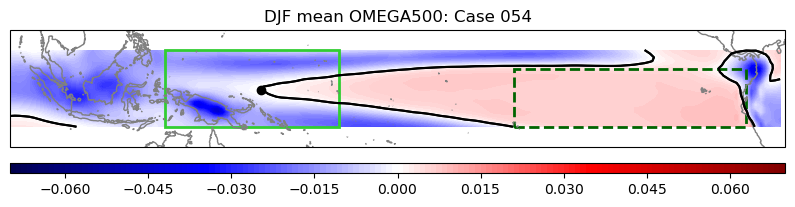

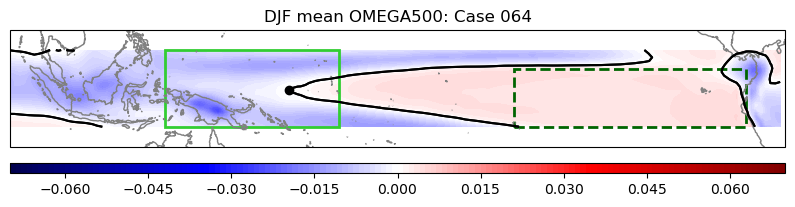

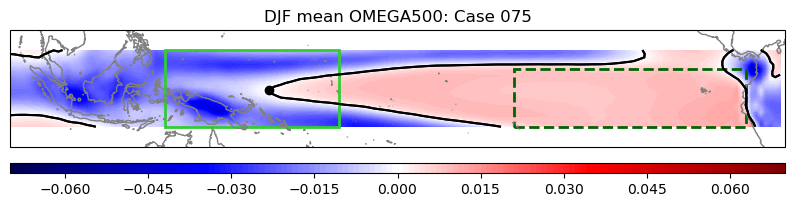

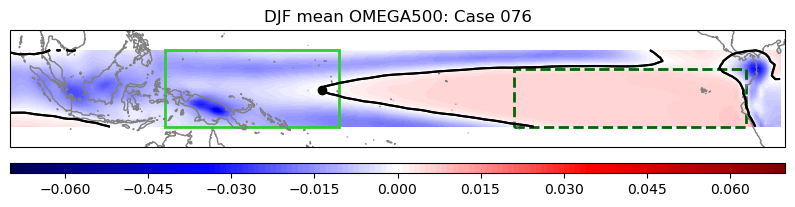

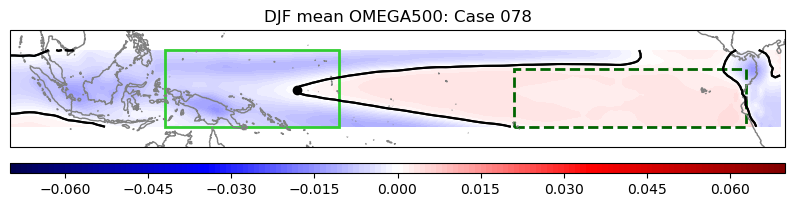

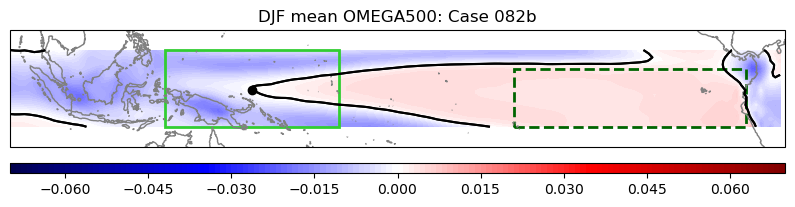

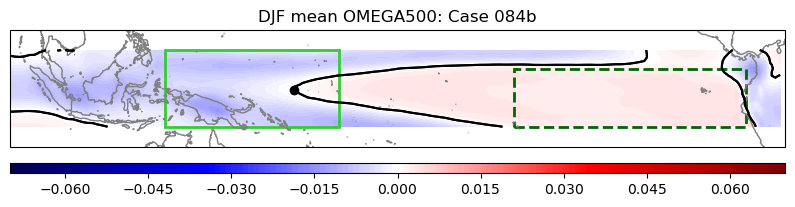

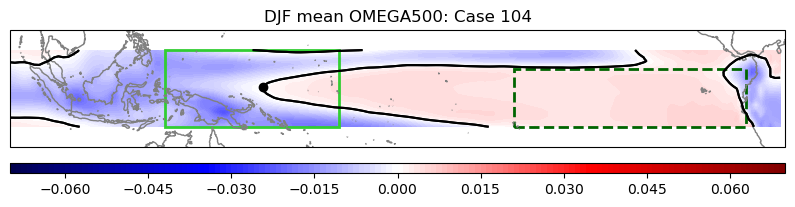

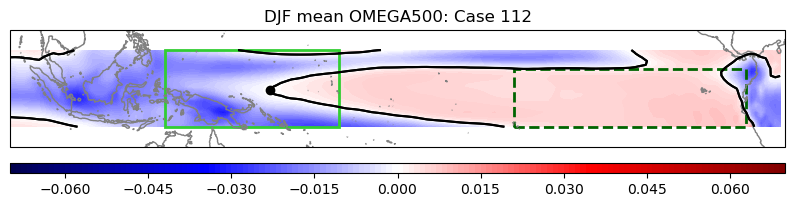

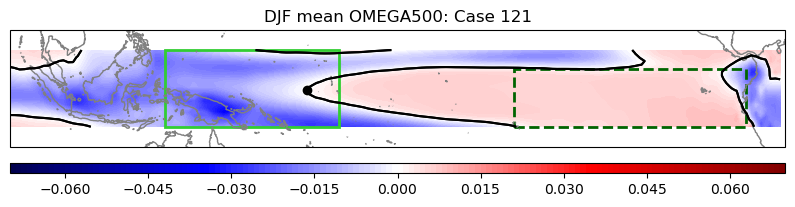

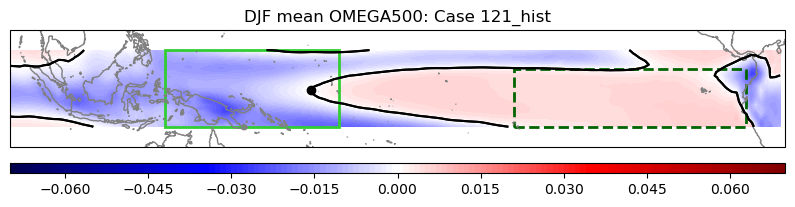

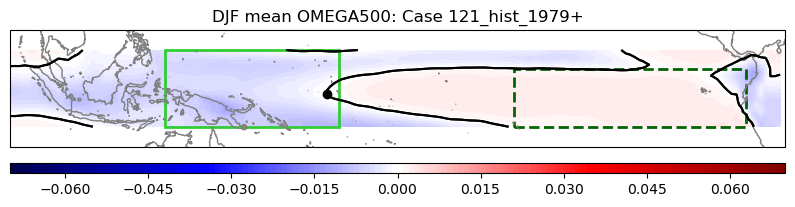

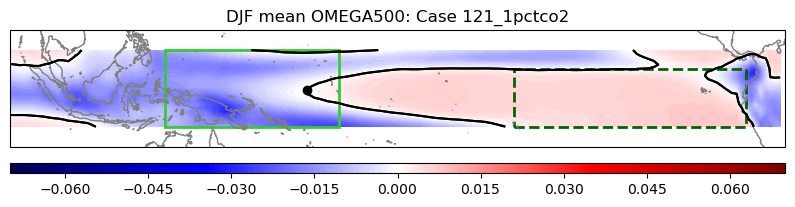

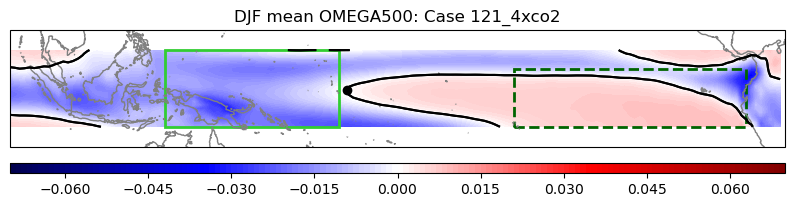

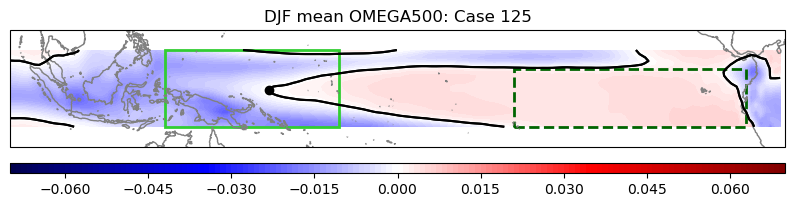

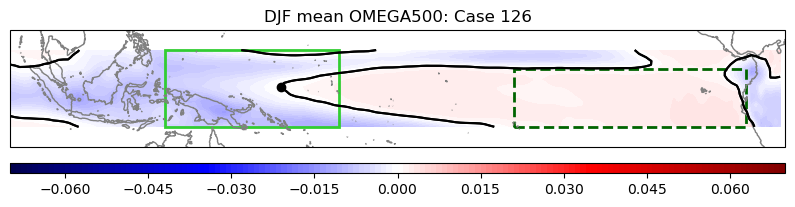

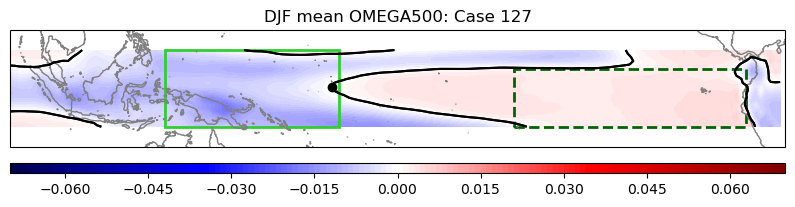

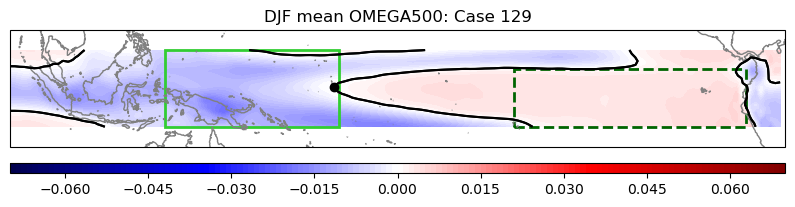

In [11]:
levs = np.arange(-0.07,0.071,0.001)

lon0 = np.full(len(time_avg_w500.case.values), np.nan)

for iCase in range(len(time_avg_w500.case.values)): 
    fig,axs = plt.subplots(1,1,figsize=(10,3),subplot_kw={"projection":ccrs.PlateCarree(central_longitude=210)})
    axs.coastlines(color='grey')
    axs.set_extent([90,290,-15,15], crs=ccrs.PlateCarree())
    
    time_avg_w500_sel = time_avg_w500.sel(lon=slice(90,290)).isel(case=iCase).load()

    c1 = axs.contourf(time_avg_w500_sel.lon.values, time_avg_w500_sel.lat.values, 
                      time_avg_w500_sel.values, levs, cmap='seismic',
                transform=ccrs.PlateCarree())

    # Add colorbar 
    cax = axs.inset_axes([0, -0.23, 1, 0.09])  # THE NEW AXES, x, y, width, height,
    cbar = fig.colorbar(c1, cax = cax, orientation="horizontal")
    c2 = axs.contour(time_avg_w500_sel.lon.values, time_avg_w500_sel.lat.values, 
                     time_avg_w500_sel.values, [-0.5, 0], colors='k', transform=ccrs.PlateCarree()) 

   
    # Add contour marker
    maybeLon = []
    maybeLat = []
    lenSeg = 0
    if c2.allsegs[1][0].size>0: 
        for iSegs in range(len(c2.allsegs[1])): 
            dat0 = c2.allsegs[1][iSegs]
            western_most_lon = np.nanmin(dat0[:,0])
            iMatchLat = np.where(dat0[:,0]==western_most_lon)[0]
            maybeLon = np.append(maybeLon, western_most_lon)
            maybeLat = np.append(maybeLat, dat0[int(iMatchLat[0]),1])
            if len(dat0)>lenSeg:
                lenSeg= len(dat0)
                iselSeg = iSegs
                
        western_most_lon = maybeLon[iselSeg]
    else:
        western_most_lon  = np.nan

    lon0[iCase] = western_most_lon

    if np.isfinite(western_most_lon):
        axs.plot(western_most_lon, maybeLat[iselSeg], 'o', alpha=1, markeredgecolor='k',
                   color='k', transform=ccrs.PlateCarree(), label=time_avg_w500_sel.case.values)
    
        c3 = axs.contour(time_avg_w500_sel.lon.values, time_avg_w500_sel.lat.values, time_avg_w500_sel.values, [0], 
                         colors='k',
                         transform=ccrs.PlateCarree()) 


    # axs.set_title('Ann mean OMEGA500: Case '+str(time_avg_w500_sel.case.values))
    axs.set_title('DJF mean OMEGA500: Case '+str(time_avg_w500_sel.case.values))

    # West Pacific
    axs.add_patch(patches.Rectangle(xy=[130, -10], width=(175-130), height=20,
                                # facecolor='none', edgecolor='limegreen',linestyle='-.',
                                facecolor='none', edgecolor='limegreen',linestyle='-',
                                linewidth=2, transform=ccrs.PlateCarree()))
    
    
    # East Pacific
    axs.add_patch(patches.Rectangle(xy=[220, -10], width=(280-220), height=15,
                                # facecolor='none', edgecolor='limegreen',linestyle='-.',
                                facecolor='none', edgecolor='darkgreen',linestyle='--',
                                linewidth=2, transform=ccrs.PlateCarree()))

    plt.show() 


## Get CESM1 and CESM2 data too 

In [12]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds

# - - - - - - - - - - - - - - - 
# Pre-process data while reading in 
# - - - - - - - - - - - - - - - 

def preprocess(ds):
    dsCorr         = cesm_correct_time(ds)
    dsCorr         = dsCorr.sel(lat=slice(-10,10))
    
    return dsCorr


In [13]:
cesm2_dir    = '/glade/campaign/collections/cdg/data/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/wap/gn/files/d20190320/'
cesm1_dir    = '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/OMEGA/'
cesm1_PS_dir = '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/PS/'
cesm1_T_dir  = '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/T/'
cesm1_PHIS_dir = '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/PHIS/'

listFiles_cesm1    = np.sort(glob.glob(cesm1_dir+'b.e11.B1850C5CN.f09_g16.005.cam.h0.OMEGA.*nc'))
listFiles_PS_cesm1 = np.sort(glob.glob(cesm1_PS_dir+'b.e11.B1850C5CN.f09_g16.005.cam.h0.PS.*nc'))
listFiles_T_cesm1  = np.sort(glob.glob(cesm1_T_dir+'b.e11.B1850C5CN.f09_g16.005.cam.h0.T.*nc'))
listFiles_PHIS_cesm1  = np.sort(glob.glob(cesm1_PHIS_dir+'b.e11.B1850C5CN.f09_g16.005.cam.h0.PHIS.*nc'))
listFiles_cesm2    = np.sort(glob.glob(cesm2_dir+'wap_Amon_CESM2_piControl_r1i1p1f1_gn*.nc'))

DS_all_cesm1 = xr.open_mfdataset(listFiles_cesm1, preprocess=preprocess, concat_dim='time', combine='nested', 
                                 decode_times=False, data_vars='minimal', parallel=True)

DS_all_PS_cesm1 = xr.open_mfdataset(listFiles_PS_cesm1, preprocess=preprocess, concat_dim='time', combine='nested', 
                                 decode_times=False, data_vars='minimal', parallel=True)

DS_all_T_cesm1 = xr.open_mfdataset(listFiles_T_cesm1, preprocess=preprocess, concat_dim='time', combine='nested', 
                                 decode_times=False, data_vars='minimal', parallel=True)

DS_all_PHIS_cesm1 = xr.open_mfdataset(listFiles_PHIS_cesm1, preprocess=preprocess, concat_dim='time', combine='nested', 
                                 decode_times=False, data_vars='minimal', parallel=True)

DS_all_cesm2 = xr.open_mfdataset(listFiles_cesm2, 
                                 preprocess=preprocess, concat_dim='time', combine='nested', 
                                 decode_times=False, data_vars='minimal', parallel=True)


In [14]:
OMEGA500_cesm2 = DS_all_cesm2.wap.sel(plev=50000)  

OMEGA500_cesm1 = isla_interp.interp_hybrid_to_pressure(
              DS_all_cesm1.OMEGA, DS_all_PS_cesm1.PS, DS_all_cesm1.hyam, DS_all_cesm1.hybm, p0=1e5, 
              new_levels = np.array([50000.]), method='log', 
              lev_dim='lev', extrapolate=False, variable='other',
              t_bot = DS_all_T_cesm1.T.isel(lev=DS_all_T_cesm1.lev.size-1), phi_sfc = DS_all_PHIS_cesm1.PHIS)


In [15]:
OMEGA500_cesm2 = np.squeeze(OMEGA500_cesm2).compute()
OMEGA500_cesm1 = np.squeeze(OMEGA500_cesm1).compute()

/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 77.16 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [16]:
%%time 

nYears_cesm1 = len(OMEGA500_cesm1.time.values)/12
nYears_cesm2 = len(OMEGA500_cesm2.time.values)/12
print('CESM1 has %i years.\nCESM2 has %i years.' % (nYears_cesm1,nYears_cesm2) )

# n_spacing    = int(100)
# nYearsPer    = int(100)
n_spacing    = int(40)  ## this is used to create the .nc files! Above is just for testing
nYearsPer    = int(40)
nSamples  = int(np.floor(np.nanmin([((nYears_cesm1 - nYearsPer) // n_spacing + 1), ((nYears_cesm2 - nYearsPer) // n_spacing + 1)])) )
print('Creating %i samples to compute ENSO over, starting every %i years and each with a window of %i years.' % (nSamples, n_spacing, nYearsPer))

#nStartInd = np.arange(0, nSamples*12, n_spacing*12)

# Create an empty array to store the reshaped data
events_cesm1 = np.zeros([nSamples, nYearsPer*12, len(OMEGA500_cesm1.lat.values), len(OMEGA500_cesm1.lon.values)])
events_cesm2 = np.zeros([nSamples, nYearsPer*12, len(OMEGA500_cesm2.lat.values), len(OMEGA500_cesm2.lon.values)])

# Create a new DataArray with the 'Event' axis
event_coords = np.arange(nSamples)
time_coords = np.arange(nYearsPer*12)

# DS_events_cesm1 = xr.DataArray(events_cesm1, coords=[event_coords, time_coords, DS_all_cesm1.lat.values, DS_all_cesm1.lon.values], 
#                                dims=["event", "time", "lat","lon"])

# DS_events_cesm2 = xr.DataArray(events_cesm2, coords=[event_coords, time_coords, DS_all_cesm2.lat.values, DS_all_cesm2.lon.values], 
                               # dims=["event", "time", "lat","lon"])

## Loop over the events and fill the new array
for iENSO in range(nSamples):
    start_year = iENSO * (n_spacing*12)
    events_cesm1[iENSO, :, :,:] = OMEGA500_cesm1.isel(time=slice(start_year, (start_year + nYearsPer*12)))
    events_cesm2[iENSO, :, :,:] = OMEGA500_cesm2.isel(time=slice(start_year, (start_year + nYearsPer*12)))

    # print('Starting with time index %i' % (start_year))


# Create a new DataArray with the 'Event' axis
event_coords = np.arange(nSamples)
# time_coords  = DS_all_cesm1.time.values[17400:18000]
time_coords  = OMEGA500_cesm1.time.values[17400:(17400+(nYearsPer*12))]

DS_cesm1_events = xr.DataArray(events_cesm1, coords=[event_coords, time_coords, OMEGA500_cesm1.lat.values, OMEGA500_cesm1.lon.values], 
                               dims=["event", "time", "lat","lon"])

DS_cesm2_events = xr.DataArray(events_cesm2, coords=[event_coords, time_coords, OMEGA500_cesm2.lat.values, OMEGA500_cesm2.lon.values], 
                               dims=["event", "time", "lat","lon"])


CESM1 has 1801 years.
CESM2 has 1200 years.
Creating 30 samples to compute ENSO over, starting every 40 years and each with a window of 40 years.
CPU times: user 303 ms, sys: 144 ms, total: 446 ms
Wall time: 479 ms


In [17]:
# Get seasonal means
month_length = DS_cesm1_events.time.dt.days_in_month
weights = ( month_length.groupby("time.season") / month_length.groupby("time.season").sum() )
# Calculate the weighted average
cesm1_all_weighted = (DS_cesm1_events * weights).groupby("time.season").sum(dim="time")
del month_length,weights

month_length = DS_cesm2_events.time.dt.days_in_month
weights = ( month_length.groupby("time.season") / month_length.groupby("time.season").sum() )
# Calculate the weighted average
cesm2_all_weighted = (DS_cesm2_events * weights).groupby("time.season").sum(dim="time")
del month_length,weights



In [18]:
# time_avg_w500_cesm1 = cesm1_all_weighted.mean(dim='season')
# time_avg_w500_cesm2 = cesm2_all_weighted.mean(dim='season')
time_avg_w500_cesm1 = cesm1_all_weighted.sel(season='DJF')
time_avg_w500_cesm2 = cesm2_all_weighted.sel(season='DJF')


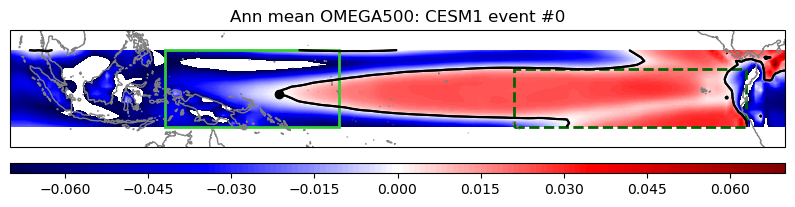

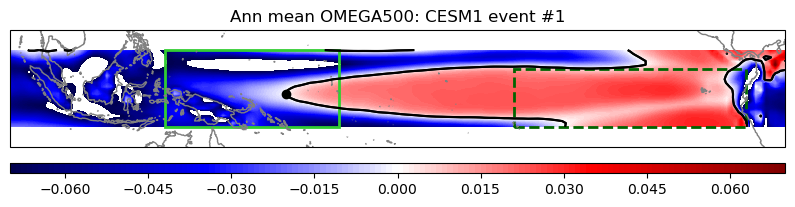

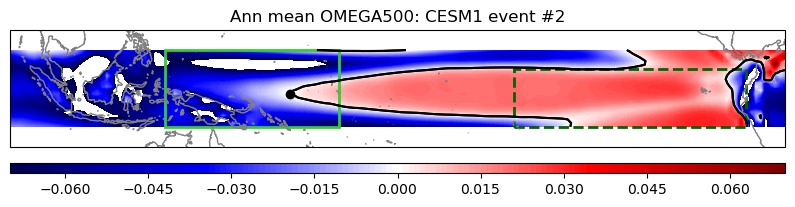

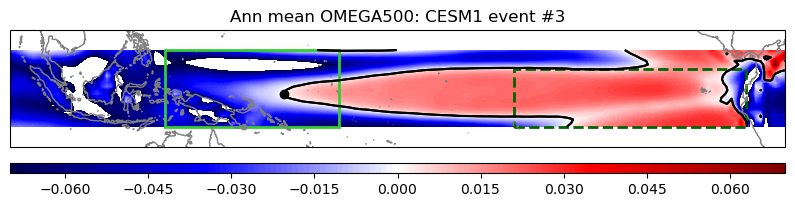

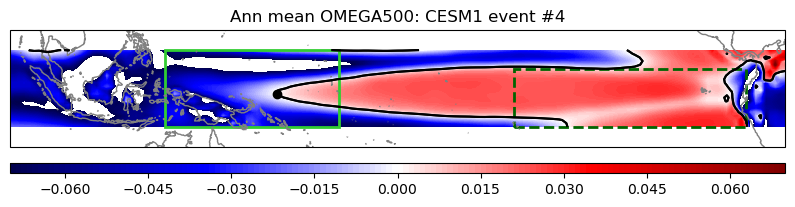

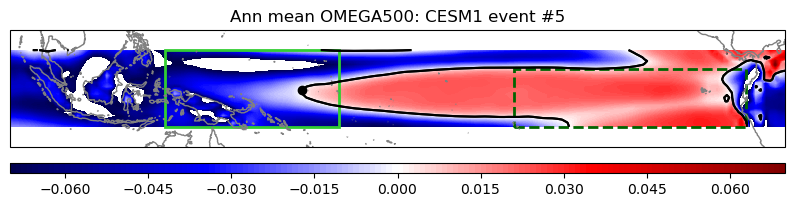

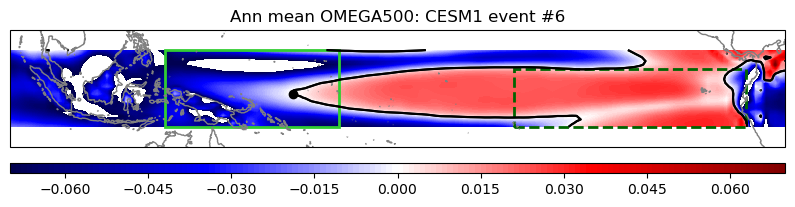

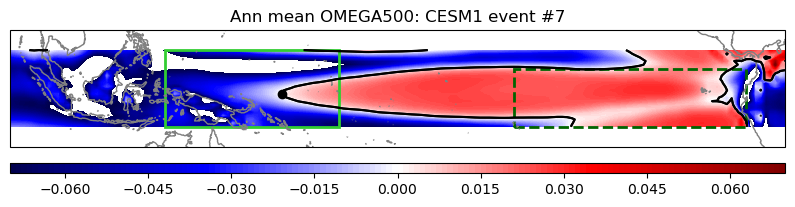

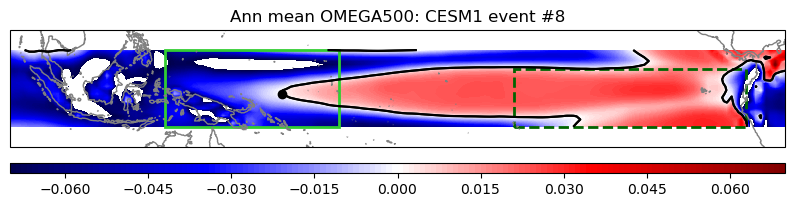

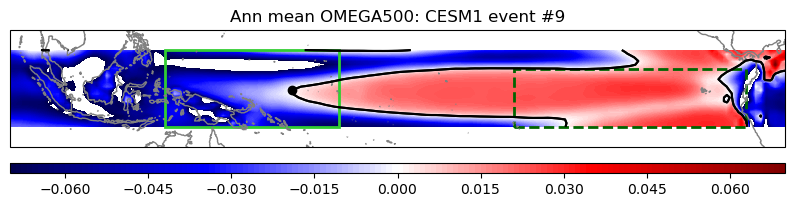

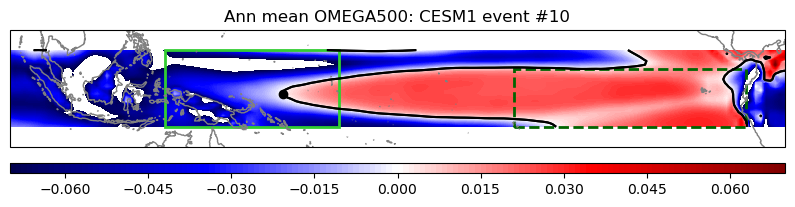

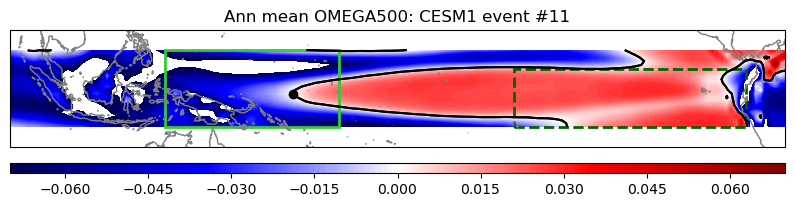

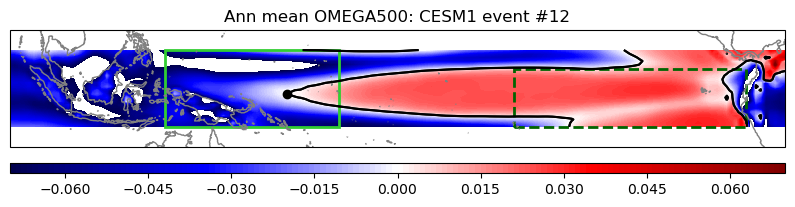

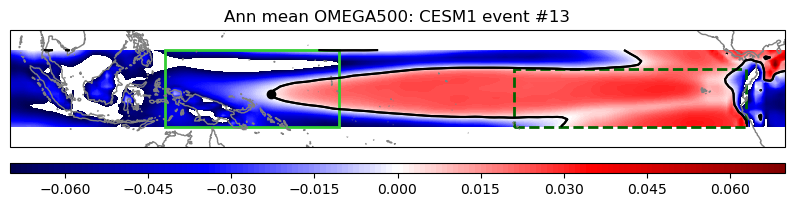

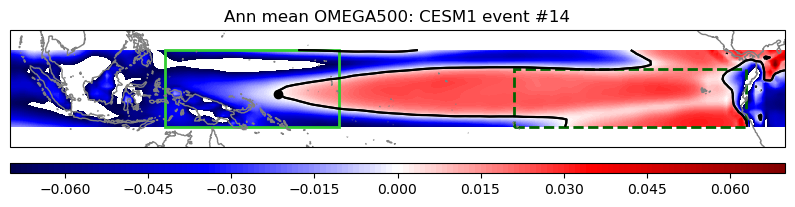

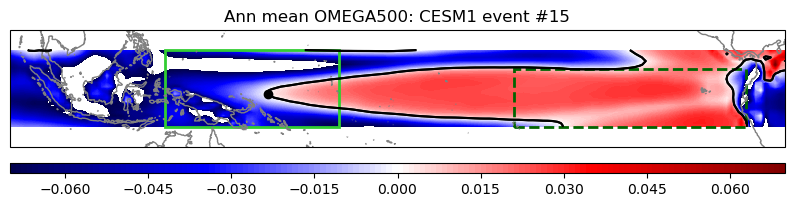

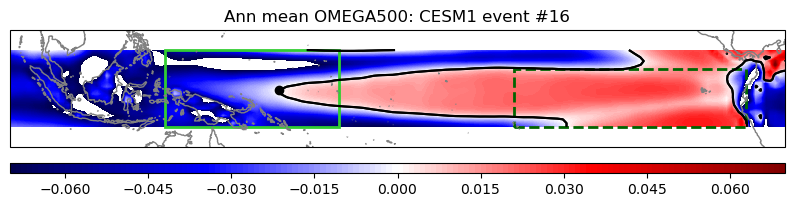

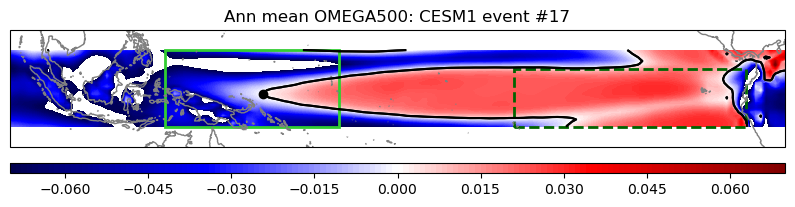

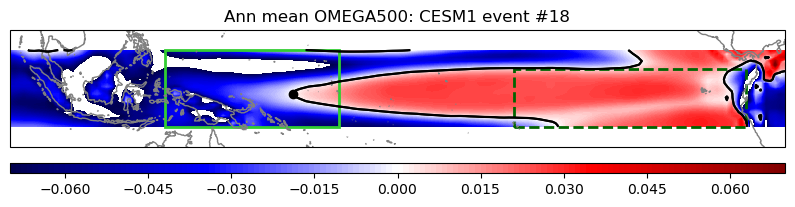

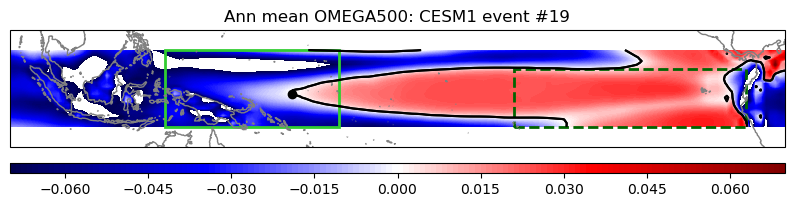

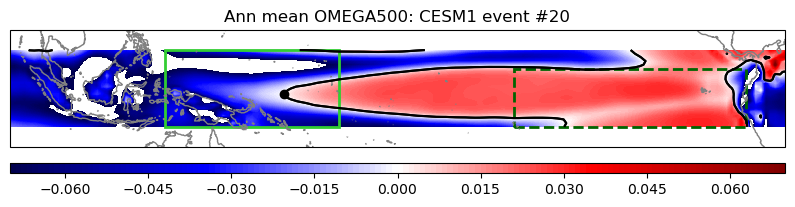

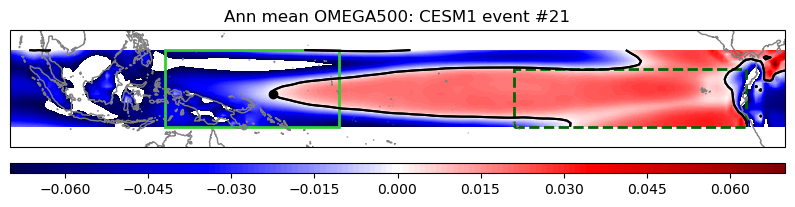

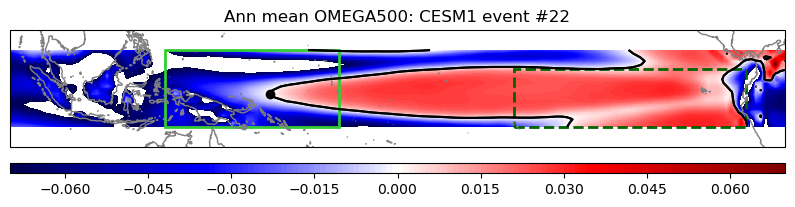

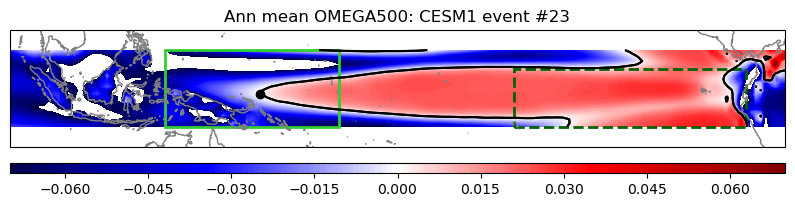

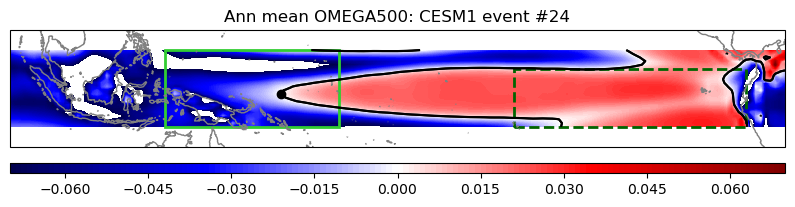

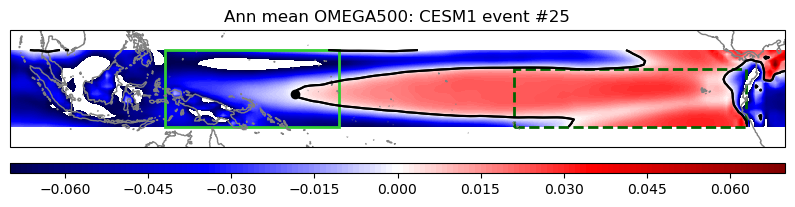

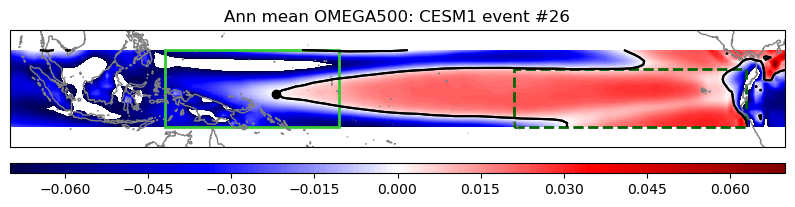

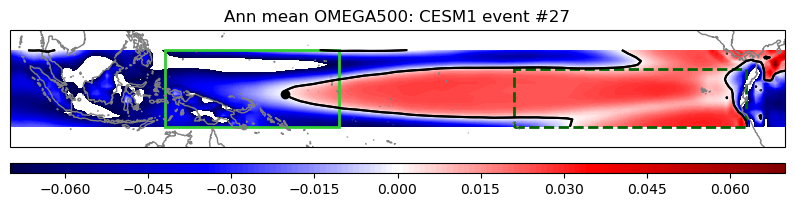

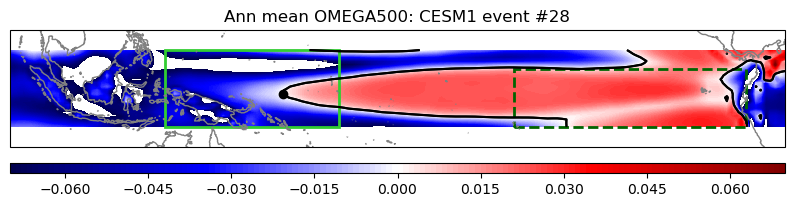

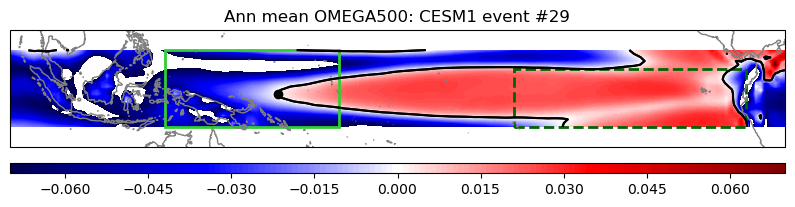

In [19]:
## CESM1
levs = np.arange(-0.07,0.071,0.001)

lon0_cesm1 = np.full(len(time_avg_w500_cesm1.event.values), np.nan)

for iCase in range(len(time_avg_w500_cesm1.event.values)): 
    fig,axs = plt.subplots(1,1,figsize=(10,3),subplot_kw={"projection":ccrs.PlateCarree(central_longitude=210)})
    axs.coastlines(color='grey')
    axs.set_extent([90,290,-15,15], crs=ccrs.PlateCarree())
    
    time_avg_w500_sel = time_avg_w500_cesm1.sel(lon=slice(90,290)).isel(event=iCase).load()

    c1 = axs.contourf(time_avg_w500_sel.lon.values, time_avg_w500_sel.lat.values, 
                      time_avg_w500_sel.values, levs, cmap='seismic',
                transform=ccrs.PlateCarree())

    # Add colorbar 
    cax = axs.inset_axes([0, -0.23, 1, 0.09])  # THE NEW AXES, x, y, width, height,
    cbar = fig.colorbar(c1, cax = cax, orientation="horizontal")
    c2 = axs.contour(time_avg_w500_sel.lon.values, time_avg_w500_sel.lat.values, 
                     time_avg_w500_sel.values, [-0.5, 0], colors='k', transform=ccrs.PlateCarree()) 

   
    # Add contour marker
    maybeLon = []
    maybeLat = []
    lenSeg = 0
    if c2.allsegs[1][0].size>0: 
        for iSegs in range(len(c2.allsegs[1])): 
            dat0 = c2.allsegs[1][iSegs]
            western_most_lon = np.nanmin(dat0[:,0])
            iMatchLat = np.where(dat0[:,0]==western_most_lon)[0]
            maybeLon = np.append(maybeLon, western_most_lon)
            maybeLat = np.append(maybeLat, dat0[int(iMatchLat[0]),1])
            if len(dat0)>lenSeg:
                lenSeg= len(dat0)
                iselSeg = iSegs
                
        western_most_lon = maybeLon[iselSeg]
    else:
        western_most_lon  = np.nan

    lon0_cesm1[iCase] = western_most_lon

    if np.isfinite(western_most_lon):
        axs.plot(western_most_lon, maybeLat[iselSeg], 'o', alpha=1, markeredgecolor='k',
                   color='k', transform=ccrs.PlateCarree(), label=time_avg_w500_sel.event.values)
    
        c3 = axs.contour(time_avg_w500_sel.lon.values, time_avg_w500_sel.lat.values, time_avg_w500_sel.values, [0], 
                         colors='k',
                         transform=ccrs.PlateCarree()) 


    axs.set_title('Ann mean OMEGA500: CESM1 event #'+str(time_avg_w500_sel.event.values))

    # West Pacific
    axs.add_patch(patches.Rectangle(xy=[130, -10], width=(175-130), height=20,
                                # facecolor='none', edgecolor='limegreen',linestyle='-.',
                                facecolor='none', edgecolor='limegreen',linestyle='-',
                                linewidth=2, transform=ccrs.PlateCarree()))
    
    
    # East Pacific
    axs.add_patch(patches.Rectangle(xy=[220, -10], width=(280-220), height=15,
                                # facecolor='none', edgecolor='limegreen',linestyle='-.',
                                facecolor='none', edgecolor='darkgreen',linestyle='--',
                                linewidth=2, transform=ccrs.PlateCarree()))

    plt.show() 


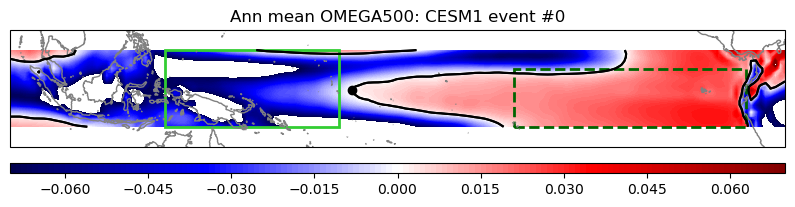

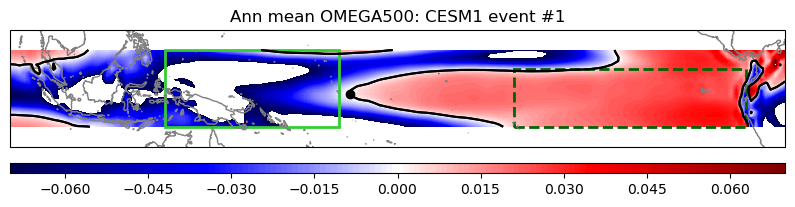

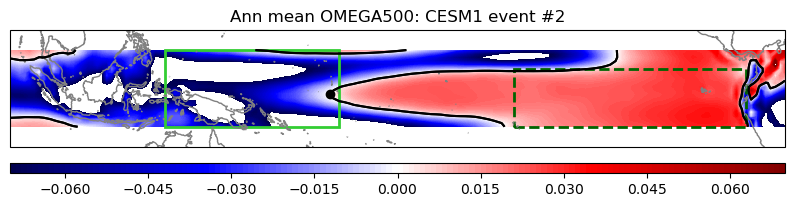

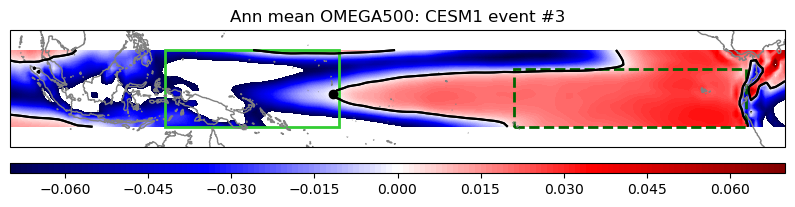

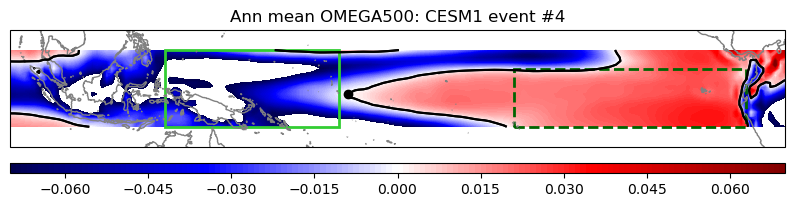

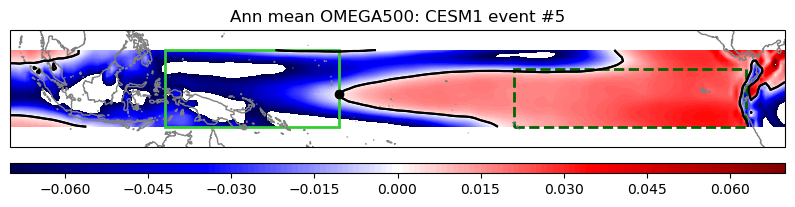

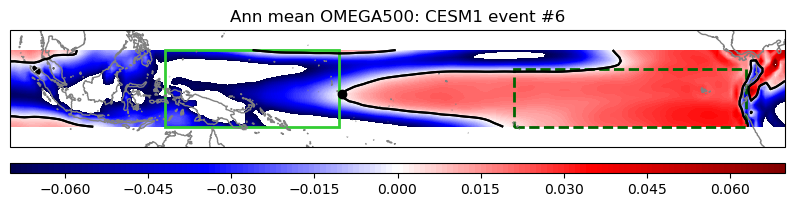

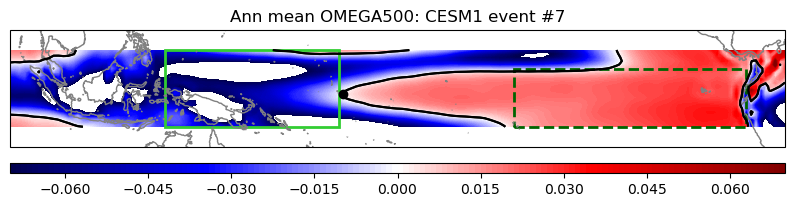

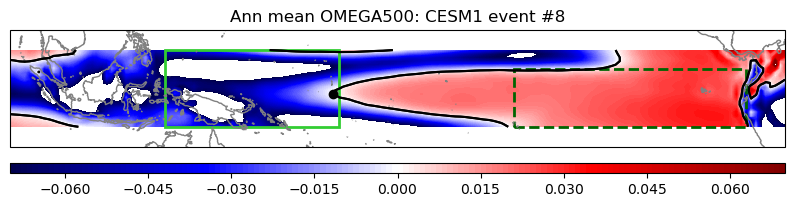

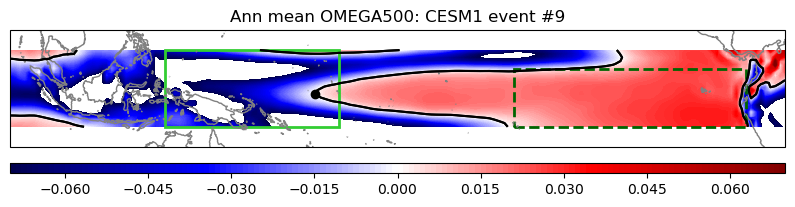

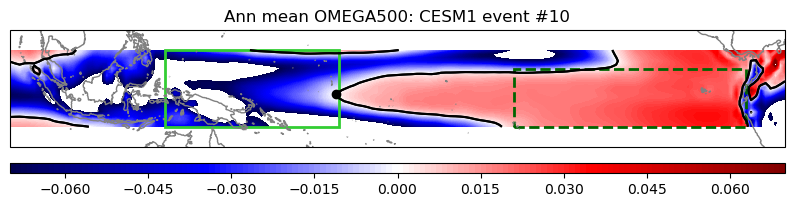

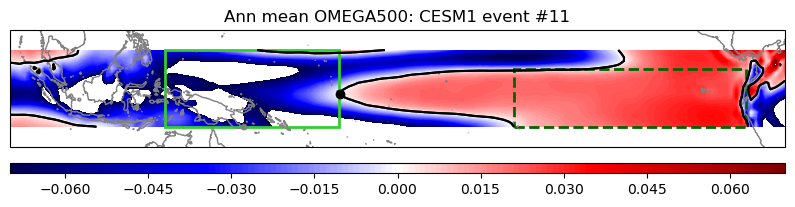

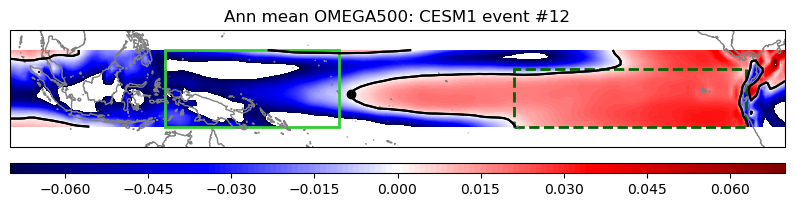

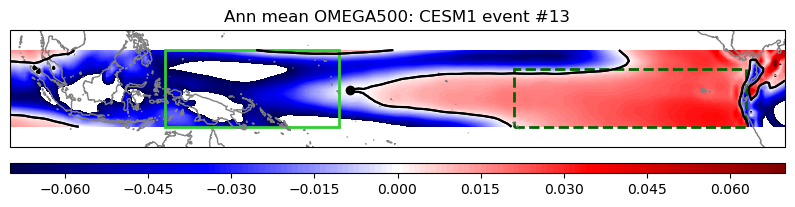

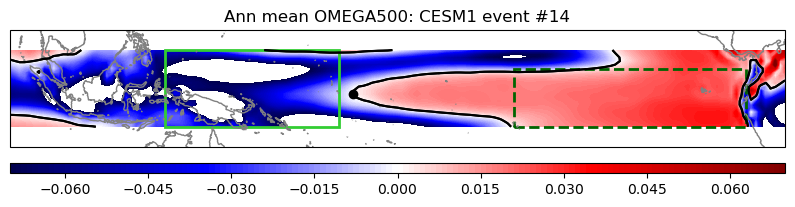

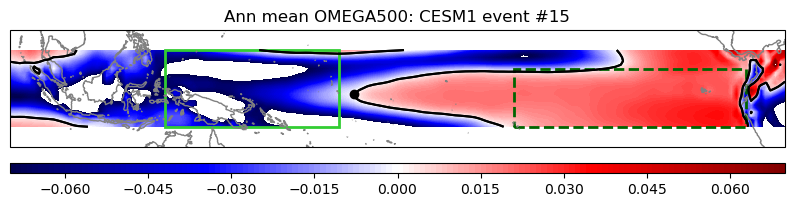

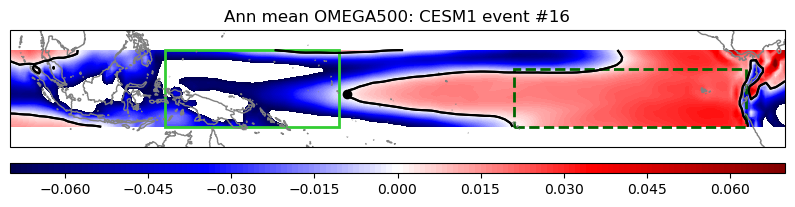

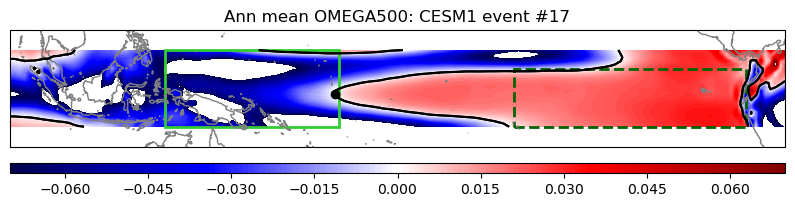

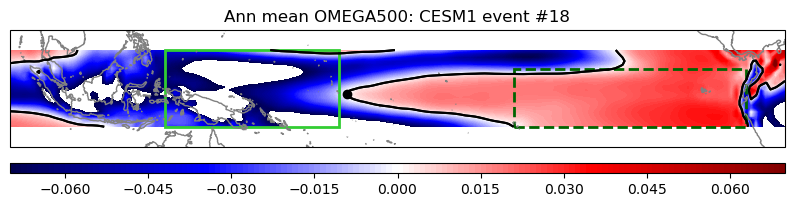

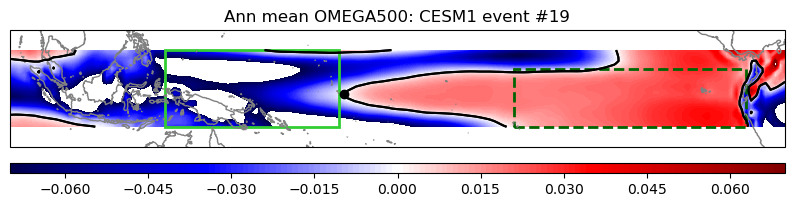

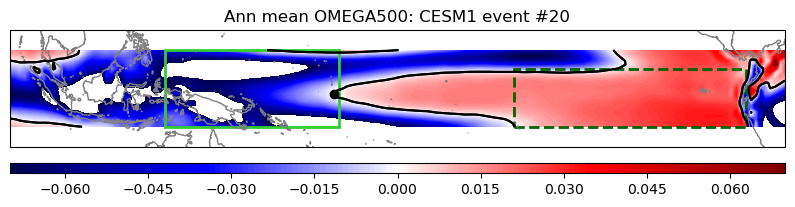

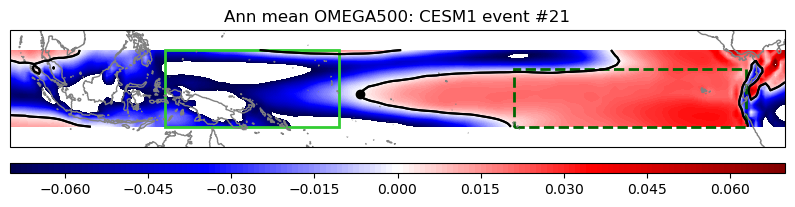

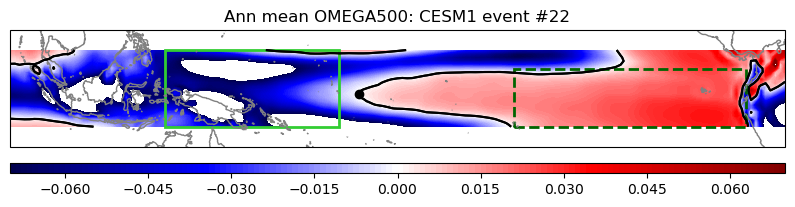

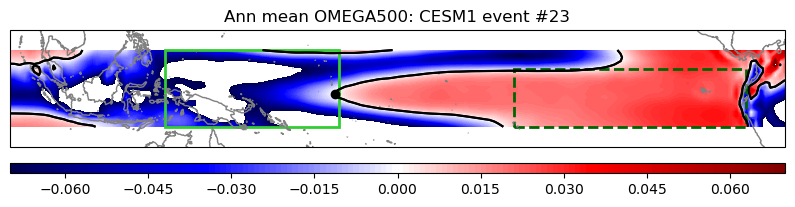

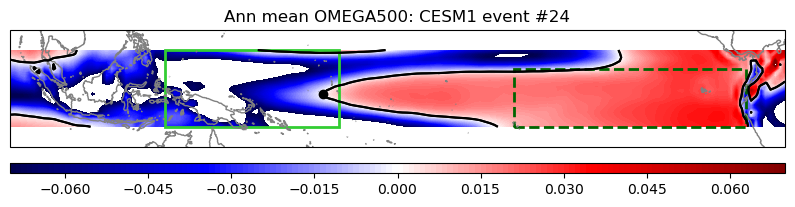

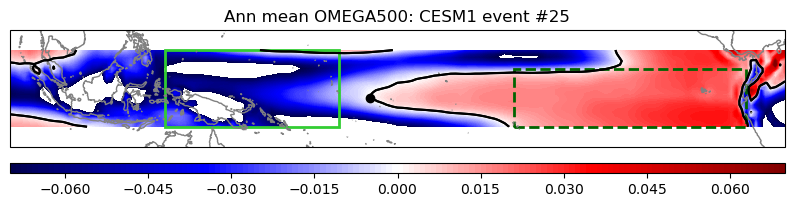

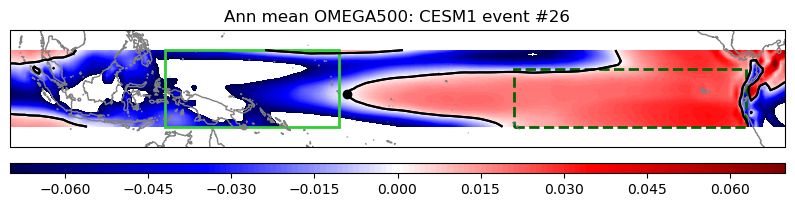

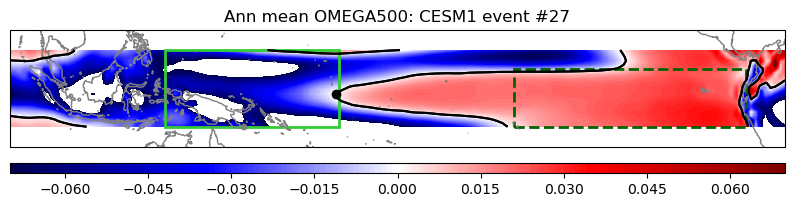

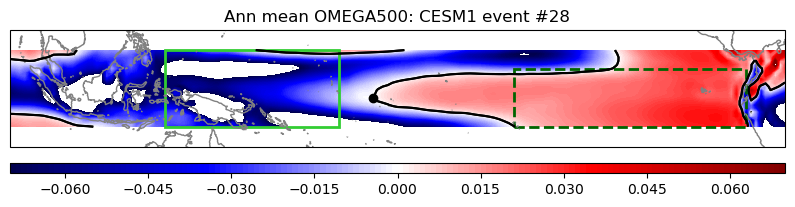

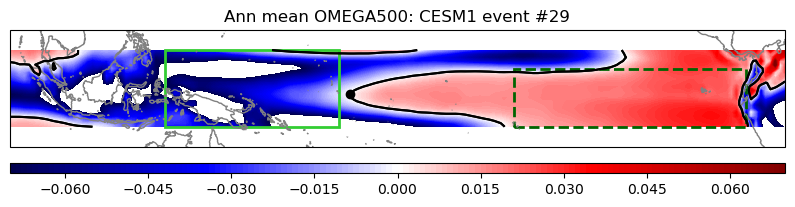

In [20]:
## CESM2
levs = np.arange(-0.07,0.071,0.001)

lon0_cesm2 = np.full(len(time_avg_w500_cesm2.event.values), np.nan)

for iCase in range(len(time_avg_w500_cesm2.event.values)): 
    fig,axs = plt.subplots(1,1,figsize=(10,3),subplot_kw={"projection":ccrs.PlateCarree(central_longitude=210)})
    axs.coastlines(color='grey')
    axs.set_extent([90,290,-15,15], crs=ccrs.PlateCarree())
    
    time_avg_w500_sel = time_avg_w500_cesm2.sel(lon=slice(90,290)).isel(event=iCase).load()

    c1 = axs.contourf(time_avg_w500_sel.lon.values, time_avg_w500_sel.lat.values, 
                      time_avg_w500_sel.values, levs, cmap='seismic',
                transform=ccrs.PlateCarree())

    # Add colorbar 
    cax = axs.inset_axes([0, -0.23, 1, 0.09])  # THE NEW AXES, x, y, width, height,
    cbar = fig.colorbar(c1, cax = cax, orientation="horizontal")
    c2 = axs.contour(time_avg_w500_sel.lon.values, time_avg_w500_sel.lat.values, 
                     time_avg_w500_sel.values, [-0.5, 0], colors='k', transform=ccrs.PlateCarree()) 

   
    # Add contour marker
    maybeLon = []
    maybeLat = []
    lenSeg = 0
    if c2.allsegs[1][0].size>0: 
        for iSegs in range(len(c2.allsegs[1])): 
            dat0 = c2.allsegs[1][iSegs]
            western_most_lon = np.nanmin(dat0[:,0])
            iMatchLat = np.where(dat0[:,0]==western_most_lon)[0]
            maybeLon = np.append(maybeLon, western_most_lon)
            maybeLat = np.append(maybeLat, dat0[int(iMatchLat[0]),1])
            if len(dat0)>lenSeg:
                lenSeg= len(dat0)
                iselSeg = iSegs
                
        western_most_lon = maybeLon[iselSeg]
    else:
        western_most_lon  = np.nan

    lon0_cesm2[iCase] = western_most_lon

    if np.isfinite(western_most_lon):
        axs.plot(western_most_lon, maybeLat[iselSeg], 'o', alpha=1, markeredgecolor='k',
                   color='k', transform=ccrs.PlateCarree(), label=time_avg_w500_sel.event.values)
    
        c3 = axs.contour(time_avg_w500_sel.lon.values, time_avg_w500_sel.lat.values, time_avg_w500_sel.values, [0], 
                         colors='k',
                         transform=ccrs.PlateCarree()) 


    axs.set_title('Ann mean OMEGA500: CESM1 event #'+str(time_avg_w500_sel.event.values))

    # West Pacific
    axs.add_patch(patches.Rectangle(xy=[130, -10], width=(175-130), height=20,
                                # facecolor='none', edgecolor='limegreen',linestyle='-.',
                                facecolor='none', edgecolor='limegreen',linestyle='-',
                                linewidth=2, transform=ccrs.PlateCarree()))
    
    
    # East Pacific
    axs.add_patch(patches.Rectangle(xy=[220, -10], width=(280-220), height=15,
                                # facecolor='none', edgecolor='limegreen',linestyle='-.',
                                facecolor='none', edgecolor='darkgreen',linestyle='--',
                                linewidth=2, transform=ccrs.PlateCarree()))

    plt.show() 


## Get obs

In [32]:
# ## Figure out western-most longitude of zero contour in pacific 
# #     This works by creating a plot with a contour and identifying the western point, but I'm closing that plot
# fig,axs = plt.subplots(1,1,figsize=(20,7),subplot_kw={"projection":ccrs.PlateCarree(central_longitude=210)})

# lon_w500, lat_w500  = getWesternPoint(time_avg_w500, 0)

# plt.close()


In [21]:
## Do the same for obs

dataDir   = '/glade/campaign/cgd/cas/observations/ERA5/mon/wap/f09/'
listFiles = np.sort(glob.glob(dataDir+'wap_*.nc'))
listFiles = listFiles[0:25]

era5_w = xr.open_mfdataset(listFiles, concat_dim='time', combine='nested', 
                                 decode_times=True, data_vars='minimal', parallel=True)

era5_w_omega = era5_w.sel(pre=500., lat=slice(-10,10))

# Get times in a useful format too
startYear = listFiles[0].split('_')[1].split('.')[0]
endYear   = listFiles[-1].split('_')[1].split('.')[0]
times     = pd.date_range(start=startYear+'-01-01', end=endYear+'-12-31', freq='MS') 
era5_w_omega['time'] = times


In [22]:
# Get seasonal means
month_length = era5_w_omega.time.dt.days_in_month
weights = ( month_length.groupby("time.season") / month_length.groupby("time.season").sum() )
# Calculate the weighted average
era5_w_omega_weighted = (era5_w_omega * weights).groupby("time.season").sum(dim="time")
del month_length,weights

# time_avg_w500_era5 = era5_w_omega_weighted.wap.mean(dim='season')
time_avg_w500_era5 = era5_w_omega_weighted.wap.sel(season='DJF')

## Figure out western-most longitude of zero contour in pacific 
#     This works by creating a plot with a contour and identifying the western point, but I'm closing that plot
fig,axs = plt.subplots(1,1,figsize=(20,7),subplot_kw={"projection":ccrs.PlateCarree(central_longitude=210)})

lon0_era5, lat_0_obs  = getWesternPoint(time_avg_w500_era5, 0)

plt.close()


## Now make some plots!

ValueError: x and y must have same first dimension, but have shapes (30,) and (1,)

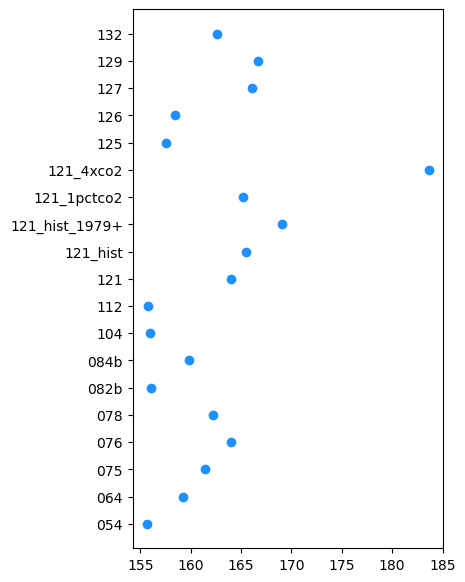

In [49]:
fig,axs=plt.subplots(1,1,figsize=(4,7))

axs.scatter(lon0, time_avg_w500.case.values, color='dodgerblue', alpha=1)
# axs[0].axhline(lonObs_zeroContour,color='k',linestyle='--')
# axs.plot(lon0_cesm1, 'CESM1', 'o', color='mediumorchid', alpha=0.5,markersize=14)
axs.plot(lon0_era5, 'ERA5', '*', color='k',markersize=14)
axs.set_title('Westernmost longitude of 0 contour for OMEGA500 ')
axs.invert_yaxis()


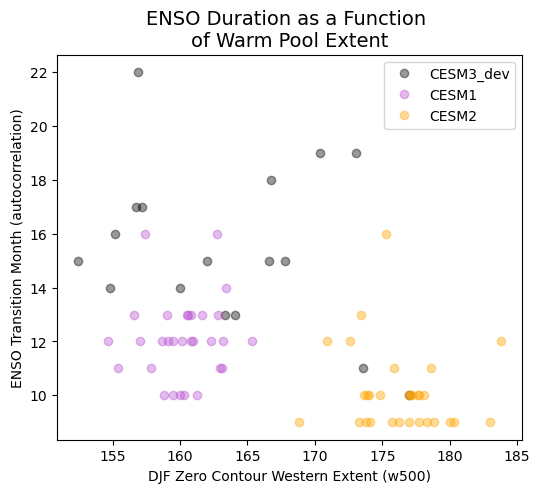

In [23]:
fig,axs = plt.subplots(1,1,figsize=(6,5))

# Get same data for y variable
countMatch = 0
for iCase in range(len(camDS_all_weighted.case.values)):
    if shortNames[iCase] != '121_hist_1979+':
    
        iCaseMatch = np.where(dev_ds.case.values==shortNames[iCase])[0][0]
        if iCaseMatch:
            if countMatch==0:
                axs.plot(lon0[iCase], dev_ds.nino34_transMonth[iCaseMatch],'ko', alpha=0.4, label='CESM3_dev')
            else:
                axs.plot(lon0[iCase], dev_ds.nino34_transMonth[iCaseMatch],'ko', alpha=0.4)
            countMatch = countMatch+1
        
            # axs.text(lon0[iCase]*1.003, dev_ds.nino34_transMonth[iCaseMatch],
            #          camDS_all_weighted.case.values[iCase], alpha=1, fontsize=12)

for iEvent in range(len(lon0_cesm1)):
    if iEvent==0:
        axs.plot(lon0_cesm1[iEvent], cesm1_ds.nino34_transMonth[iEvent], 'o', color='mediumorchid', alpha=0.4, label='CESM1')
        axs.plot(lon0_cesm2[iEvent], cesm2_ds.nino34_transMonth[iEvent], 'o', color='orange', alpha=0.4, label='CESM2')
    
    else:
        axs.plot(lon0_cesm1[iEvent], cesm1_ds.nino34_transMonth[iEvent], 'o', color='mediumorchid', alpha=0.4)
        axs.plot(lon0_cesm2[iEvent], cesm2_ds.nino34_transMonth[iEvent], 'o', color='orange', alpha=0.4)
    

# axs.set_xlabel('AnnMean Zero Contour Western Extent (w500)')
axs.set_xlabel('DJF Zero Contour Western Extent (w500)')
axs.set_ylabel('ENSO Transition Month (autocorrelation)')
axs.set_title('ENSO Duration as a Function \nof Warm Pool Extent',fontsize=14)
axs.legend()

# axs.set_xlim([153,175])
